In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
from scipy.stats import genextreme, t
from scipy.optimize import minimize
import pandas as pd
from matplotlib import cm
from scipy.special import gamma, ndtr
import warnings
warnings.filterwarnings("ignore")

# 1. Base Copula class
class Copula:
    """Base class for copulas"""
    def __init__(self):
        self.params = None
        self.name = "Base"
    
    def fit(self, u1, u2):
        """Fit copula parameters to data"""
        raise NotImplementedError("Subclasses must implement this method")
    
    def cdf(self, u1, u2):
        """Calculate copula CDF"""
        raise NotImplementedError("Subclasses must implement this method")
    
    def sample(self, n_samples):
        """Generate samples from the copula"""
        raise NotImplementedError("Subclasses must implement this method")
    
    def aic(self, u1, u2):
        """Calculate AIC for the fitted copula"""
        raise NotImplementedError("Subclasses must implement this method")
    
    def _neg_log_likelihood(self, params, u1, u2):
        """Calculate negative log-likelihood for parameter estimation"""
        raise NotImplementedError("Subclasses must implement this method")

# 2. Gaussian Copula
class GaussianCopula(Copula):
    def __init__(self):
        super().__init__()
        self.correlation = None
        self.name = "Gaussian"
    
    def fit(self, u1, u2):
        """
        Fit the Gaussian copula to uniform data
        """
        # Convert to standard normal
        z1 = stats.norm.ppf(u1)
        z2 = stats.norm.ppf(u2)
        
        # Calculate Pearson correlation
        self.correlation = np.corrcoef(z1, z2)[0, 1]
        self.params = self.correlation
        return self
    
    def _neg_log_likelihood(self, params, u1, u2):
        """Negative log-likelihood for Gaussian copula"""
        rho = params[0]
        if rho <= -1 or rho >= 1:
            return np.inf  # Invalid correlation
            
        z1 = stats.norm.ppf(u1)
        z2 = stats.norm.ppf(u2)
        
        # Log likelihood formula for Gaussian copula
        loglik = -0.5 * np.log(1 - rho**2) - (rho**2*(z1**2 + z2**2) - 2*rho*z1*z2)/(2*(1-rho**2))
        return -np.sum(loglik)
    
    def cdf(self, u1, u2):
        """
        Compute the Gaussian copula CDF
        """
        if np.isscalar(u1) and np.isscalar(u2):
            z1 = stats.norm.ppf(u1)
            z2 = stats.norm.ppf(u2)
            return stats.multivariate_normal.cdf(
                [z1, z2], 
                mean=[0, 0], 
                cov=[[1, self.correlation], [self.correlation, 1]]
            )
        else:
            result = np.zeros_like(u1)
            for i in range(len(u1)):
                z1 = stats.norm.ppf(u1[i])
                z2 = stats.norm.ppf(u2[i])
                result[i] = stats.multivariate_normal.cdf(
                    [z1, z2], 
                    mean=[0, 0], 
                    cov=[[1, self.correlation], [self.correlation, 1]]
                )
            return result
    
    def sample(self, n_samples):
        """
        Generate samples from the copula
        """
        # Generate correlated normal variables
        mean = [0, 0]
        cov = [[1, self.correlation], [self.correlation, 1]]
        z1, z2 = np.random.multivariate_normal(mean, cov, n_samples).T
        
        # Transform to uniform
        u1 = stats.norm.cdf(z1)
        u2 = stats.norm.cdf(z2)
        
        return u1, u2
    
    def aic(self, u1, u2):
        """Calculate AIC for Gaussian copula"""
        k = 1  # Number of parameters (correlation)
        ll = -self._neg_log_likelihood([self.correlation], u1, u2)
        return -2 * ll + 2 * k

# 3. Student's t Copula
class StudentTCopula(Copula):
    def __init__(self):
        super().__init__()
        self.correlation = None
        self.df = None  # Degrees of freedom
        self.name = "Student's t"
    
    def fit(self, u1, u2):
        """
        Fit the Student's t copula to uniform data
        """
        # Initial values
        init_params = [0.5, 4.0]  # [correlation, df]
        
        # Bounds
        bounds = [(-0.99, 0.99), (2.1, 30.0)]  # Correlation between -1 and 1, df > 2
        
        # Find optimal parameters
        result = optimize.minimize(
            lambda params: self._neg_log_likelihood(params, u1, u2),
            init_params,
            bounds=bounds,
            method='L-BFGS-B'
        )
        
        self.correlation, self.df = result.x
        self.params = (self.correlation, self.df)
        return self
    
    def _neg_log_likelihood(self, params, u1, u2):
        """Negative log-likelihood for Student's t copula"""
        rho, df = params
        if rho <= -1 or rho >= 1 or df <= 2:
            return np.inf  # Invalid parameters
            
        # Transform uniform to quantiles of t distribution
        t1 = stats.t.ppf(u1, df)
        t2 = stats.t.ppf(u2, df)
        
        # Compute log-PDF of bivariate t
        term1 = np.log(gamma((df + 2) / 2)) + np.log(gamma(df / 2)) - 2 * np.log(gamma((df + 1) / 2))
        term2 = -0.5 * np.log(1 - rho**2)
        
        w = (t1**2 - 2*rho*t1*t2 + t2**2) / (1 - rho**2)
        term3 = -((df + 2) / 2) * np.log(1 + w/df)
        
        log_pdf = term1 + term2 + term3
        
        # Adjust for transformation (add log of pdf of marginals)
        log_pdf -= stats.t.logpdf(t1, df) + stats.t.logpdf(t2, df)
        
        return -np.sum(log_pdf)
    
    def cdf(self, u1, u2):
        """
        Approximate the Student's t copula CDF
        """
        # For scalar inputs
        if np.isscalar(u1) and np.isscalar(u2):
            t1 = stats.t.ppf(u1, self.df)
            t2 = stats.t.ppf(u2, self.df)
            
            # Use simulation for t-copula CDF (more accurate approach would use numerical integration)
            # This is an approximation - a true implementation would use a library with 
            # multivariate t distribution CDF capabilities
            
            samples = self.sample(10000)
            return np.mean((samples[0] <= u1) & (samples[1] <= u2))
        else:
            # For array inputs
            result = np.zeros_like(u1)
            samples = self.sample(10000)
            sample_points = np.column_stack((samples[0], samples[1]))
            
            for i in range(len(u1)):
                result[i] = np.mean((samples[0] <= u1[i]) & (samples[1] <= u2[i]))
            return result
    
    def sample(self, n_samples):
        """
        Generate samples from the Student's t copula
        """
        # Generate correlated standard normal variables
        mean = [0, 0]
        cov = [[1, self.correlation], [self.correlation, 1]]
        z1, z2 = np.random.multivariate_normal(mean, cov, n_samples).T
        
        # Generate chi-squared random variable with df degrees of freedom
        w = np.random.chisquare(self.df, n_samples) / self.df
        
        # Transform to t distributed variables
        t1 = z1 / np.sqrt(w)
        t2 = z2 / np.sqrt(w)
        
        # Transform to uniform using t CDF
        u1 = stats.t.cdf(t1, self.df)
        u2 = stats.t.cdf(t2, self.df)
        
        return u1, u2
    
    def aic(self, u1, u2):
        """Calculate AIC for Student's t copula"""
        k = 2  # Number of parameters (correlation and df)
        ll = -self._neg_log_likelihood([self.correlation, self.df], u1, u2)
        return -2 * ll + 2 * k

# 4. Gumbel Copula (Archimedean family)
class GumbelCopula(Copula):
    def __init__(self):
        super().__init__()
        self.theta = None  # Dependency parameter
        self.name = "Gumbel"
    
    def fit(self, u1, u2):
        """
        Fit the Gumbel copula to uniform data
        """
        # Initial parameter value (theta >= 1)
        init_params = [1.5]
        
        # Bounds for theta
        bounds = [(1.0001, 20.0)]  # theta > 1
        
        # Optimize using MLE
        result = optimize.minimize(
            lambda params: self._neg_log_likelihood(params, u1, u2),
            init_params,
            bounds=bounds,
            method='L-BFGS-B'
        )
        
        self.theta = result.x[0]
        self.params = self.theta
        return self
    
    def _neg_log_likelihood(self, params, u1, u2):
        """Negative log-likelihood for Gumbel copula"""
        theta = params[0]
        if theta <= 1:
            return np.inf  # Invalid parameter
        
        # Transform to uniform (0,1)
        u1 = np.clip(u1, 1e-10, 1-1e-10)
        u2 = np.clip(u2, 1e-10, 1-1e-10)
        
        # Gumbel copula log-likelihood
        t1 = -np.log(u1)
        t2 = -np.log(u2)
        
        w = (t1**theta + t2**theta)**(1/theta)
        
        logpdf = (
            np.log(w**(-2+2/theta)) + 
            np.log((t1*t2)**(theta-1)) + 
            np.log(theta - 1 + w**theta) -
            np.log(u1 * u2)
        )
        
        return -np.sum(logpdf)
    
    def cdf(self, u1, u2):
        """
        Compute the Gumbel copula CDF
        
        C(u1,u2) = exp(-((-log(u1))^θ + (-log(u2))^θ)^(1/θ))
        """
        if np.isscalar(u1) and np.isscalar(u2):
            t1 = -np.log(max(u1, 1e-10))
            t2 = -np.log(max(u2, 1e-10))
            return np.exp(-((t1**self.theta + t2**self.theta)**(1/self.theta)))
        else:
            u1_s = np.maximum(u1, 1e-10)
            u2_s = np.maximum(u2, 1e-10)
            t1 = -np.log(u1_s)
            t2 = -np.log(u2_s)
            return np.exp(-((t1**self.theta + t2**self.theta)**(1/self.theta)))
    
    def sample(self, n_samples):
        """
        Generate samples from the Gumbel copula using conditional sampling
        """
        # Generate uniform samples
        v1 = np.random.uniform(0, 1, n_samples)
        v2 = np.random.uniform(0, 1, n_samples)
        
        # First variable is just uniform
        u1 = v1
        
        # Second variable is conditional on first
        # This is complex and requires numerical methods
        # Here we use a simplified approach with inverse transform sampling
        
        # Function to compute conditional CDF of u2 given u1
        def conditional_cdf(u2, u1):
            t1 = -np.log(u1)
            t2 = -np.log(u2)
            numerator = u1 * (-t1**(self.theta-1)) * ((t1**self.theta + t2**self.theta)**(1/self.theta-1)) * (t2**(self.theta-1))
            denominator = u2 * ((t1**self.theta + t2**self.theta)**(1/self.theta))
            return numerator / denominator
        
        # For each u1, find u2 such that conditional_cdf(u2|u1) = v2
        u2 = np.zeros_like(u1)
        
        # For each u1, find u2 such that conditional_cdf(u2|u1) = v2
        # This is a simplification - a proper implementation would solve for the exact inverse
        for i in range(n_samples):
            # For Gumbel, we use a specialized sampler based on stable distributions
            gamma_val = np.random.gamma(1/self.theta, 1)
            stable_var = np.random.gamma(1, 1)
            stable_val = stable_var / gamma_val
            
            t1 = -np.log(u1[i])
            u2[i] = np.exp(-(stable_val * t1)**self.theta)
        
        return u1, u2
    
    def aic(self, u1, u2):
        """Calculate AIC for Gumbel copula"""
        k = 1  # Number of parameters (theta)
        ll = -self._neg_log_likelihood([self.theta], u1, u2)
        return -2 * ll + 2 * k

# 5. Joe Copula (another Archimedean copula)
class JoeCopula(Copula):
    def __init__(self):
        super().__init__()
        self.theta = None  # Dependency parameter
        self.name = "Joe"
    
    def fit(self, u1, u2):
        """
        Fit the Joe copula to uniform data
        """
        # Initial parameter value (theta > 1)
        init_params = [1.5]
        
        # Bounds for theta
        bounds = [(1.0001, 20.0)]  # theta > 1
        
        # Optimize using MLE
        result = optimize.minimize(
            lambda params: self._neg_log_likelihood(params, u1, u2),
            init_params,
            bounds=bounds,
            method='L-BFGS-B'
        )
        
        self.theta = result.x[0]
        self.params = self.theta
        return self
    
    def _neg_log_likelihood(self, params, u1, u2):
        """Negative log-likelihood for Joe copula"""
        theta = params[0]
        if theta <= 1:
            return np.inf  # Invalid parameter
        
        # Transform to uniform (0,1)
        u1 = np.clip(u1, 1e-10, 1-1e-10)
        u2 = np.clip(u2, 1e-10, 1-1e-10)
        
        # Joe copula log-likelihood
        t1 = 1 - u1
        t2 = 1 - u2
        
        term1 = (theta - 1) * (np.log(1 - t1**theta) + np.log(1 - t2**theta))
        term2 = (1 - theta) * np.log(1 - (1 - t1**theta) * (1 - t2**theta) + (1 - t1**theta) * (1 - t2**theta) * (1 - (1-t1)*(1-t2))**theta)
        term3 = np.log(theta) + (theta - 1) * (np.log(1-t1) + np.log(1-t2)) + (2*theta - 1) * np.log(1 - (1-t1)*(1-t2))
        
        logpdf = term1 + term2 + term3
        
        return -np.sum(logpdf)
    
    def cdf(self, u1, u2):
        """
        Compute the Joe copula CDF
        
        C(u1,u2) = 1 - ((1-u1)^θ + (1-u2)^θ - (1-u1)^θ * (1-u2)^θ)^(1/θ)
        """
        if np.isscalar(u1) and np.isscalar(u2):
            t1 = 1 - u1
            t2 = 1 - u2
            return 1 - ((t1**self.theta + t2**self.theta - t1**self.theta * t2**self.theta)**(1/self.theta))
        else:
            t1 = 1 - u1
            t2 = 1 - u2
            return 1 - ((t1**self.theta + t2**self.theta - t1**self.theta * t2**self.theta)**(1/self.theta))
    
    def sample(self, n_samples):
        """
        Generate samples from the Joe copula
        """
        # Generate uniform samples
        v1 = np.random.uniform(0, 1, n_samples)
        v2 = np.random.uniform(0, 1, n_samples)
        
        # First variable is just uniform
        u1 = v1
        
        # For Joe copula, we use a simplified approach
        # A proper implementation would use conditional sampling methods
        u2 = np.zeros_like(u1)
        
        # Simplified sampling based on empirical approximation
        for i in range(n_samples):
            # Generate from an approximation
            t = np.random.uniform(0, 1)
            w = np.random.uniform(0, 1)
            
            # Transform based on t and correlation parameter
            s = (1 - (1-u1[i])**self.theta) ** (1/self.theta)
            u2[i] = 1 - (1 - w**(1/(self.theta-1)) * s**(self.theta/(self.theta-1)))**(1/self.theta)
        
        return u1, u2
    
    def aic(self, u1, u2):
        """Calculate AIC for Joe copula"""
        k = 1  # Number of parameters (theta)
        ll = -self._neg_log_likelihood([self.theta], u1, u2)
        return -2 * ll + 2 * k

# 6. Function to fit univariate GEV distribution (same as before)
def fit_gev(data):
    """
    Fit a GEV distribution to the data using Maximum Likelihood Estimation
    """
    # Initial parameters (shape, loc, scale)
    init_params = [0.1, np.mean(data), np.std(data)]
    
    # Negative log-likelihood function for GEV
    def neg_log_likelihood(params):
        shape, loc, scale = params
        if scale <= 0:
            return np.inf  # Scale must be positive
        return -np.sum(genextreme.logpdf(data, shape, loc, scale))
    
    # Minimize the negative log-likelihood
    result = minimize(neg_log_likelihood, init_params, method='Nelder-Mead')
    return result.x

# 7. Function to transform data to uniform using the fitted GEV (same as before)
def to_uniform(data, gev_params):
    """
    Transform data to uniform [0,1] using the fitted GEV CDF
    """
    shape, loc, scale = gev_params
    return genextreme.cdf(data, shape, loc, scale)

# 8. Function to estimate return levels for GEV distribution (same as before)
def gev_return_level(gev_params, return_period):
    """
    Calculate return level for a given return period
    """
    shape, loc, scale = gev_params
    # Return level formula
    p = 1 - 1/return_period
    if abs(shape) < 1e-6:  # Shape close to zero (Gumbel)
        return loc - scale * np.log(-np.log(p))
    else:
        return loc + scale * ((-np.log(p))**(-shape) - 1) / shape

# 9. Modified main function to perform bivariate GEV analysis with copula selection
def bivariate_gev_analysis(data1, data2, copula_type='gaussian', return_periods=[2, 5, 10, 20, 50, 100], n_samples=10000):
    """
    Perform bivariate GEV analysis using selected copula
    
    Parameters:
    -----------
    data1, data2 : array-like
        The two variables for bivariate analysis
    copula_type : str
        Type of copula to use ('gaussian', 'student_t', 'gumbel', 'joe')
    return_periods : list
        Return periods to calculate
    n_samples : int
        Number of samples for simulation
        
    Returns:
    --------
    results : dict
        Dictionary containing fitted parameters and results
    """
    # Fit univariate GEV distributions
    gev_params1 = fit_gev(data1)
    gev_params2 = fit_gev(data2)
    
    print(f"GEV Parameters for Variable 1: shape={gev_params1[0]:.4f}, loc={gev_params1[1]:.4f}, scale={gev_params1[2]:.4f}")
    print(f"GEV Parameters for Variable 2: shape={gev_params2[0]:.4f}, loc={gev_params2[1]:.4f}, scale={gev_params2[2]:.4f}")
    
    # Transform to uniform using GEV CDFs
    u1 = to_uniform(data1, gev_params1)
    u2 = to_uniform(data2, gev_params2)
    
    # Create and fit the selected copula
    if copula_type.lower() == 'gaussian':
        copula = GaussianCopula().fit(u1, u2)
        print(f"Fitted Gaussian Copula Correlation: {copula.correlation:.4f}")
    elif copula_type.lower() == 'student_t':
        copula = StudentTCopula().fit(u1, u2)
        print(f"Fitted Student's t Copula Parameters: correlation={copula.correlation:.4f}, df={copula.df:.4f}")
    elif copula_type.lower() == 'gumbel':
        copula = GumbelCopula().fit(u1, u2)
        print(f"Fitted Gumbel Copula Parameter: theta={copula.theta:.4f}")
    elif copula_type.lower() == 'joe':
        copula = JoeCopula().fit(u1, u2)
        print(f"Fitted Joe Copula Parameter: theta={copula.theta:.4f}")
    else:
        raise ValueError(f"Copula type '{copula_type}' not recognized. Choose from 'gaussian', 'student_t', 'gumbel', or 'joe'.")
    
    # Calculate univariate return levels
    return_levels1 = [gev_return_level(gev_params1, rp) for rp in return_periods]
    return_levels2 = [gev_return_level(gev_params2, rp) for rp in return_periods]
    
    # Generate joint samples from copula and transform back to original scale
    sim_u1, sim_u2 = copula.sample(n_samples)
    sim_x1 = genextreme.ppf(sim_u1, *gev_params1)
    sim_x2 = genextreme.ppf(sim_u2, *gev_params2)
    
    # Store results
    results = {
        'gev_params1': gev_params1,
        'gev_params2': gev_params2,
        'copula': copula,
        'return_periods': return_periods,
        'return_levels1': return_levels1,
        'return_levels2': return_levels2,
        'sim_data': (sim_x1, sim_x2)
    }
    
    return results

# 10. Function to select the best copula based on AIC
def select_best_copula(data1, data2):
    """
    Select the best copula based on AIC criterion
    
    Parameters:
    -----------
    data1, data2 : array-like
        The two variables for bivariate analysis
        
    Returns:
    --------
    best_copula : str
        The name of the best copula
    copula_results : dict
        Dictionary with all fitted copulas and their AIC values
    """
    # Fit univariate GEV distributions
    gev_params1 = fit_gev(data1)
    gev_params2 = fit_gev(data2)
    
    # Transform to uniform using GEV CDFs
    u1 = to_uniform(data1, gev_params1)
    u2 = to_uniform(data2, gev_params2)
    
    # Fit all copulas
    gaussian_copula = GaussianCopula().fit(u1, u2)
    student_t_copula = StudentTCopula().fit(u1, u2)
    gumbel_copula = GumbelCopula().fit(u1, u2)
    joe_copula = JoeCopula().fit(u1, u2)
    
    # Calculate AIC for each copula
    gaussian_aic = gaussian_copula.aic(u1, u2)
    student_t_aic = student_t_copula.aic(u1, u2)
    gumbel_aic = gumbel_copula.aic(u1, u2)
    joe_aic = joe_copula.aic(u1, u2)
    
    # Print AIC values
    print("AIC Values:")
    print(f"Gaussian Copula: {gaussian_aic:.4f}")
    print(f"Student's t Copula: {student_t_aic:.4f}")
    print(f"Gumbel Copula: {gumbel_aic:.4f}")
    print(f"Joe Copula: {joe_aic:.4f}")
    
    # Find best copula (lowest AIC)
    aic_values = {
        'gaussian': gaussian_aic,
        'student_t': student_t_aic,
        'gumbel': gumbel_aic,
        'joe': joe_aic
    }
    
    best_copula = min(aic_values, key=aic_values.get)
    print(f"Best copula based on AIC: {best_copula}")
    
    # Store fitted copulas
    copula_results = {
        'gaussian': gaussian_copula,
        'student_t': student_t_copula,
        'gumbel': gumbel_copula,
        'joe': joe_copula,
        'aic_values': aic_values,
        'best_copula': best_copula
    }
    
    return best_copula, copula_results

# 11. Plot function remains similar but with copula type in title
def plot_return_surface(results, return_period=100, nx=100, ny=100):
    """
    Calculate and plot the bivariate return surface for a given return period
    """
    gev_params1 = results['gev_params1']
    gev_params2 = results['gev_params2']
    copula = results['copula']
    
    # Create grid of points in original space
    x1_min, x1_max = np.percentile(results['sim_data'][0], [0.1, 99.9])
    x2_min, x2_max = np.percentile(results['sim_data'][1], [0.1, 99.9])
    
    x1_grid = np.linspace(x1_min, x1_max, nx)
    x2_grid = np.linspace(x2_min, x2_max, ny)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    
    # Transform to uniform space
    U1 = genextreme.cdf(X1, *gev_params1)
    U2 = genextreme.cdf(X2, *gev_params2)
    
    # Calculate joint CDF
    joint_cdf = np.zeros_like(X1)
    for i in range(nx):
        for j in range(ny):
            joint_cdf[j, i] = copula.cdf(U1[j, i], U2[j, i])
    
    # Calculate joint return period (years)
    joint_return_period = 1 / (1 - joint_cdf)
    
    # Create the plot
    fig = plt.figure(figsize=(14, 6))
    
    # 3D Surface plot
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(X1, X2, joint_return_period, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Variable 1')
    ax1.set_ylabel('Variable 2')
    ax1.set_zlabel('Return Period (years)')
    ax1.set_title(f'Bivariate Return Period Surface ({copula.name} Copula)')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    # Contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X1, X2, joint_return_period, levels=[1, 2, 5, 10, 20, 50, 100, 200], cmap='viridis')
    ct = ax2.contour(X1, X2, joint_return_period, levels=[return_period], colors='r', linewidths=2)
    ax2.clabel(ct, inline=1, fontsize=10, fmt='%1.0f')
    ax2.set_xlabel('Variable 1')
    ax2.set_ylabel('Variable 2')
    ax2.set_title(f'{return_period}-year Return Level Curve ({copula.name} Copula)')
    fig.colorbar(contour, ax=ax2, label='Return Period (years)')
    
    plt.tight_layout()
    return fig

In [2]:
np.random.seed(42)
n_years = 100

# Simulate correlated data from GEV distributions
# Variable 1: shape=0.1, loc=50, scale=10
# Variable 2: shape=-0.05, loc=20, scale=5

# Step 1: Generate correlated normal variables with correlation 0.7
mean = [0, 0]
cov = [[1, 0.7], [0.7, 1]]
z1, z2 = np.random.multivariate_normal(mean, cov, n_years).T

# Step 2: Transform to uniform using normal CDF
u1 = stats.norm.cdf(z1)
u2 = stats.norm.cdf(z2)

# Step 3: Transform to GEV using inverse CDF (quantile function)
data1 = genextreme.ppf(u1, 0.1, 50, 10)
data2 = genextreme.ppf(u2, -0.05, 20, 5)

# Select the best copula
print("Selecting the best copula...")
best_copula, copula_results = select_best_copula(data1, data2)

# Perform bivariate GEV analysis with the best copula
print(f"\nPerforming bivariate GEV analysis using {best_copula} copula...")
results = bivariate_gev_analysis(data1, data2, copula_type=best_copula)

# Also try with a specified copula
specified_copula = 'gumbel'
print(f"\nPerforming bivariate GEV analysis using {specified_copula} copula...")
results_gumbel = bivariate_gev_analysis(data1, data2, copula_type=specified_copula)

Selecting the best copula...
AIC Values:
Gaussian Copula: -45.9435
Student's t Copula: -454.0204
Gumbel Copula: -445.9289
Joe Copula: 105.1290
Best copula based on AIC: student_t

Performing bivariate GEV analysis using student_t copula...
GEV Parameters for Variable 1: shape=0.1634, loc=51.5536, scale=9.3214
GEV Parameters for Variable 2: shape=-0.0150, loc=20.8609, scale=4.6075
Fitted Student's t Copula Parameters: correlation=0.5086, df=2.1000

Performing bivariate GEV analysis using gumbel copula...
GEV Parameters for Variable 1: shape=0.1634, loc=51.5536, scale=9.3214
GEV Parameters for Variable 2: shape=-0.0150, loc=20.8609, scale=4.6075
Fitted Gumbel Copula Parameter: theta=1.0106


Plotting return surfaces...


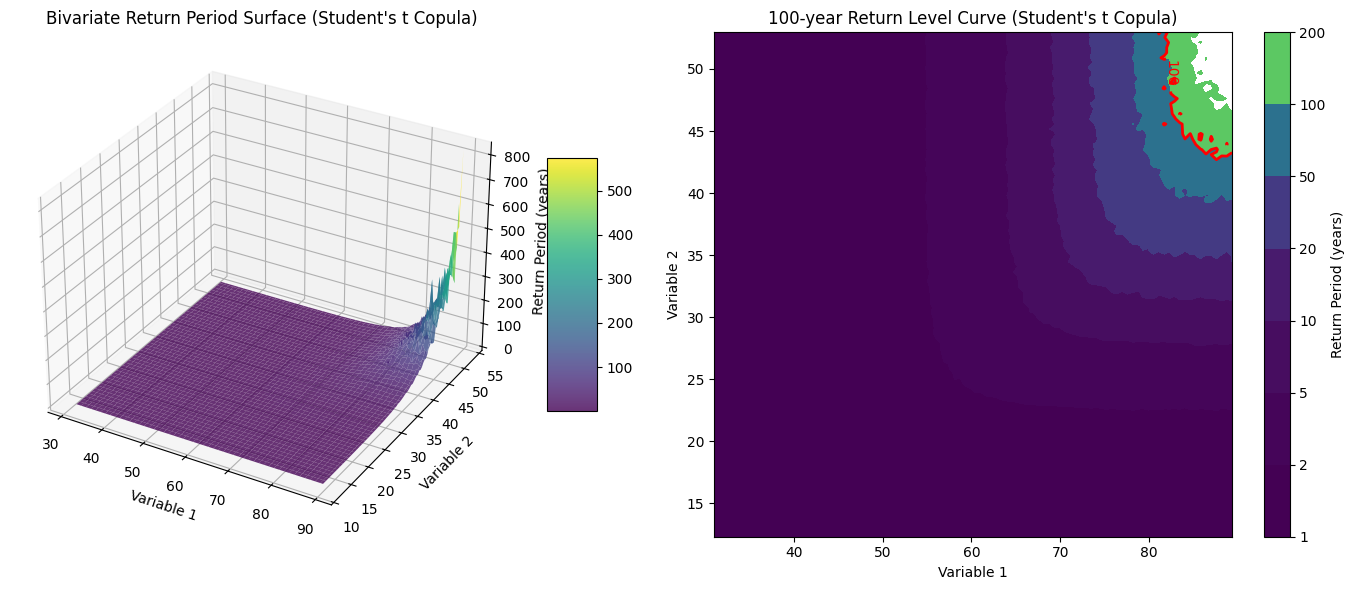

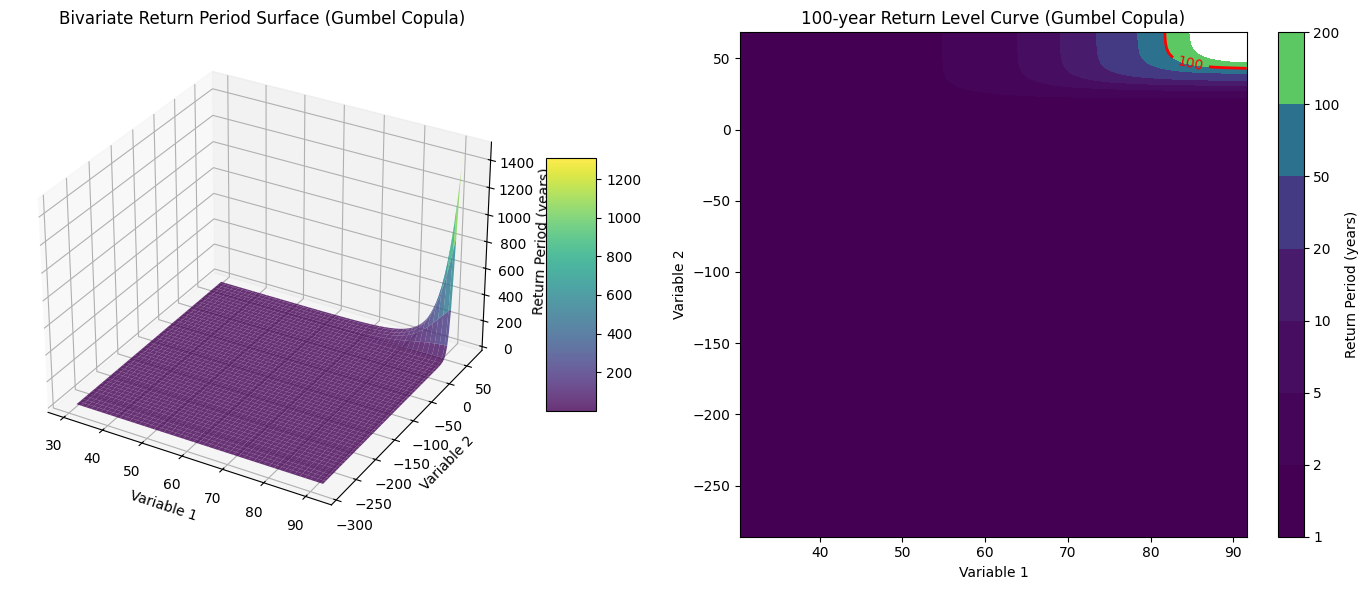

In [3]:
# Plot results for both
print("Plotting return surfaces...")
fig1 = plot_return_surface(results, return_period=100)
fig2 = plot_return_surface(results_gumbel, return_period=100)


Comparing different copulas for 100-year return level...
GEV Parameters for Variable 1: shape=0.1634, loc=51.5536, scale=9.3214
GEV Parameters for Variable 2: shape=-0.0150, loc=20.8609, scale=4.6075
Fitted Gaussian Copula Correlation: 0.6172
GEV Parameters for Variable 1: shape=0.1634, loc=51.5536, scale=9.3214
GEV Parameters for Variable 2: shape=-0.0150, loc=20.8609, scale=4.6075
Fitted Student's t Copula Parameters: correlation=0.5086, df=2.1000
GEV Parameters for Variable 1: shape=0.1634, loc=51.5536, scale=9.3214
GEV Parameters for Variable 2: shape=-0.0150, loc=20.8609, scale=4.6075
Fitted Gumbel Copula Parameter: theta=1.0106
GEV Parameters for Variable 1: shape=0.1634, loc=51.5536, scale=9.3214
GEV Parameters for Variable 2: shape=-0.0150, loc=20.8609, scale=4.6075
Fitted Joe Copula Parameter: theta=1.0001


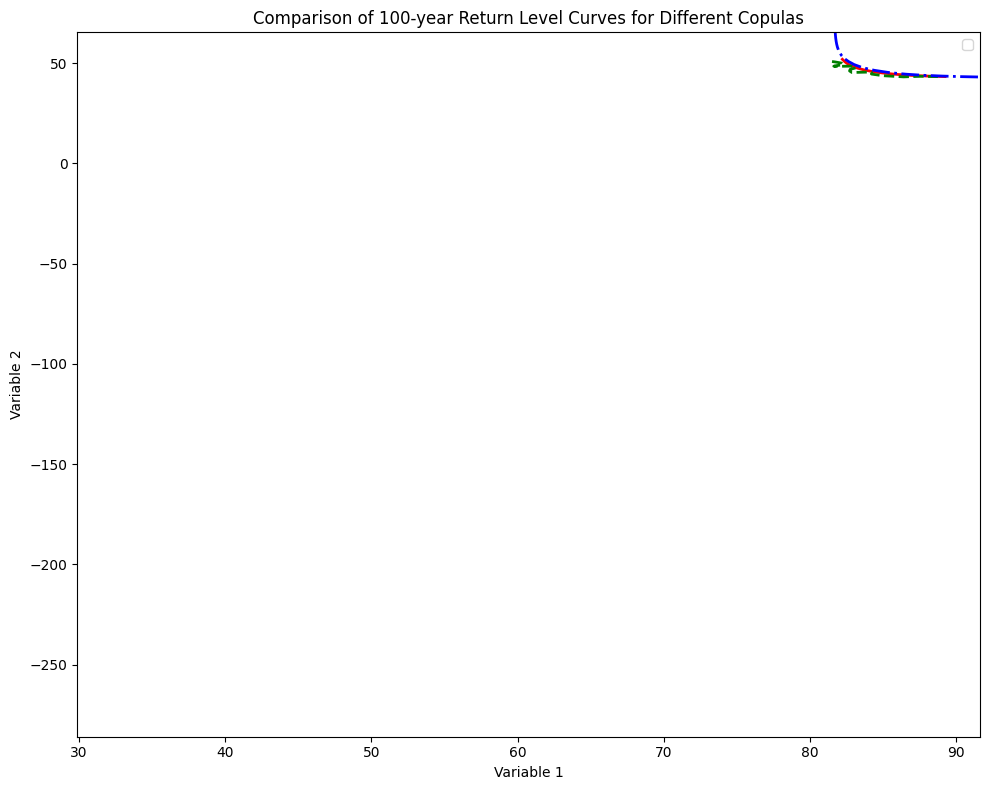

In [5]:
# Compare different copulas
print("\nComparing different copulas for 100-year return level...")
fig3, ax = plt.subplots(figsize=(10, 8))

# Loop through all copulas and plot their 100-year return level curves
colors = ['r', 'g', 'b', 'm']
linestyles = ['-', '--', '-.', ':']

for i, (copula_name, color, ls) in enumerate(zip(['gaussian', 'student_t', 'gumbel', 'joe'], colors, linestyles)):
    results_i = bivariate_gev_analysis(data1, data2, copula_type=copula_name, n_samples=5000)
    
    # Create grid for contour
    x1_min, x1_max = np.percentile(results_i['sim_data'][0], [0.1, 99.9])
    x2_min, x2_max = np.percentile(results_i['sim_data'][1], [0.1, 99.9])
    
    x1_grid = np.linspace(x1_min, x1_max, 50)
    x2_grid = np.linspace(x2_min, x2_max, 50)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    
    # Transform to uniform
    U1 = genextreme.cdf(X1, *results_i['gev_params1'])
    U2 = genextreme.cdf(X2, *results_i['gev_params2'])
    
    # Calculate joint CDF
    joint_cdf = np.zeros_like(X1)
    for j in range(len(x1_grid)):
            for k in range(len(x2_grid)):
                joint_cdf[k, j] = results_i['copula'].cdf(U1[k, j], U2[k, j])
    
    # Joint return period
    joint_return_period = 1 / (1 - joint_cdf)
    
    # Plot 100-year contour
    ct = ax.contour(X1, X2, joint_return_period, levels=[100], colors=color, 
            linestyles=ls, linewidths=2, label=f"{copula_name.capitalize()} (AIC={copula_results['aic_values'][copula_name]:.2f})")
    
ax.set_xlabel('Variable 1')
ax.set_ylabel('Variable 2')
ax.set_title('Comparison of 100-year Return Level Curves for Different Copulas')
ax.legend()
   
plt.tight_layout()